# Manejo de Datos Faltantes: Imputacion

### Importar librerias

In [1]:
import janitor  # limpiar datos
import matplotlib.pyplot as plt # visualizacion de datos
import missingno    # exploracion de valores faltantes
import nhanes.load  # libreria con los datos a analizar
import numpy as np  # calculos numericos
import pandas as pd # trabajar con dataframe
import scipy.stats  # trabjar con estadisticos
import seaborn as sns   #   visualizacion estadistica
# import session_info
# sklearn contiene los modelos a utilizar
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

### Importar Funciones Personalizadas

In [2]:
# permite utilizar funciones contenidas en otro notebook
%run utils.ipynb

### Configuracion de las Graficas

In [3]:
%matplotlib inline

# tamaño de los graficos
sns.set(
    rc={
        'figure.figsize':(8, 6)
    }
)

# estilo de los graficos
sns.set_style('whitegrid')

## El problema de trabajar con valores faltantes

In [4]:
# trabajamos con un dataset que nos provee statsmodels

airquality_df = (
    sm.datasets.get_rdataset('airquality') # datos de juguete
    .data   # acceder a los datos
    .clean_names(   # limpieza de datos
        case_type = 'snake'
    )
    .add_column('year',1973) # agregamos una columna de indicador
    .assign(    # convertimos una variable a una fecha
        date = lambda df: pd.to_datetime(df[['year', 'month', 'day']])
    )
    .sort_values(by = 'date')   # ordenamos el df segun la fecha
    .set_index('date')  # seteamos el indice con la fecha
)

airquality_df

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


In [5]:
# variables que contienen valores faltantes
(
    airquality_df
    .isna()
    .any()
)

ozone       True
solar_r     True
wind       False
temp       False
month      False
day        False
year       False
dtype: bool

Las variables ozone y solar_r contiene valores faltantes

Ajustemos un modelo de regresion lineal con statsmodel sobre los datos

In [6]:
# temperatura en funcion del ozono que contiene valores faltantes
(
    smf.ols(
        formula='temp ~ ozone',
        data=airquality_df
    )
    .fit() # ajuste del modelo sobre los datos
    .summary() # resumen estadistico del modelo
    .tables[0] # muestra solo el contenido de la tabla en la posicion 0
)

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Tue, 18 Apr 2023",Prob (F-statistic):,2.93e-18
Time:,13:26:45,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


vemos que se aplico el modelo OLS sobre un total de 116 observaciones con un R cuadrado de 0.488. Como se nota tampoco se obtuvo un error al ejecutarse el modelo a pesar que la variable ozono contiene missing. El dataset contiene mas de 150 observaciones por lo que el modelo omitio las observaciones con valores faltantes en la variable ozono

Ahora vamos a considerar otra variable y aplicar el modelo, en este caso solar_r

In [7]:
# temperatura en funcion del ozono y de solar_r
(
    smf.ols(
        formula='temp ~ ozone + solar_r',
        data=airquality_df
    )
    .fit() # ajuste del modelo sobre los datos
    .summary() # resumen estadistico del modelo
    .tables[0] # muestra solo el contenido de la tabla en la posicion 0
)

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Tue, 18 Apr 2023",Prob (F-statistic):,1.47e-16
Time:,13:26:45,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


En este modelo, tambien se perdieron observaciones ya que se aplico sobre 111. Se obtuvo un valor de R cuadrado de 0.491. Aunque se quisiera comparar ambos modelos mediante su valor de R cuadrado para saber cual de los dos se ajusto mejor, es un error hacerlo debido a que los modelos estan basados sobre diferentes numeros de observaciones.

## Reto: Datos de supervivientes

In [8]:
# dataframe de statsmodels con datos de prueba 
suvirval_df = sm.datasets.get_rdataset('flchain', 'survival').data
suvirval_df

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,97,F,1997,5.700,4.860,10,1.7,0,85,1,Circulatory
1,92,F,2000,0.870,0.683,1,0.9,0,1281,1,Neoplasms
2,94,F,1997,4.360,3.850,10,1.4,0,69,1,Circulatory
3,92,F,1996,2.420,2.220,9,1.0,0,115,1,Circulatory
4,93,F,1996,1.320,1.690,6,1.1,0,1039,1,Circulatory
...,...,...,...,...,...,...,...,...,...,...,...
7869,52,F,1995,1.210,1.610,6,1.0,0,4997,0,NaN
7870,52,F,1999,0.858,0.581,1,0.8,0,3652,0,NaN
7871,54,F,2002,1.700,1.720,8,NaN,0,2507,0,NaN
7872,53,F,1995,1.710,2.690,9,NaN,0,4982,0,NaN


In [9]:
# variables con valores faltantes
(
    suvirval_df
    .isna()
    .any()
)

age           False
sex           False
sample.yr     False
kappa         False
lambda        False
flc.grp       False
creatinine     True
mgus          False
futime        False
death         False
chapter        True
dtype: bool

Las variables creatinine y chapter contienen missing

In [10]:
# cantidad de valores faltantes por variable

(
    suvirval_df
    .isnull()
    .sum()
)

age              0
sex              0
sample.yr        0
kappa            0
lambda           0
flc.grp          0
creatinine    1350
mgus             0
futime           0
death            0
chapter       5705
dtype: int64

Hay 1350 missing para la variable creatinine y 5705 para chapter

### Ajusta algunos modelos para predecir si una persona va a sobrevivir o no utilizando a las variables con valores faltantes como predictoras

In [11]:
# Modelo 1
# death en funcion de creatinine

(
    smf.ols(
        formula='death ~ creatinine',
        data=suvirval_df
    )
    .fit() # ajuste del modelo sobre los datos
    .summary() # resumen estadistico del modelo
    .tables[0] # muestra solo el contenido de la tabla en la posicion 0
)

Dep. Variable:,death,R-squared:,0.025
Model:,OLS,Adj. R-squared:,0.025
Method:,Least Squares,F-statistic:,165.0
Date:,"Tue, 18 Apr 2023",Prob (F-statistic):,2.59e-37
Time:,13:26:47,Log-Likelihood:,-4089.4
No. Observations:,6524,AIC:,8183.
Df Residuals:,6522,BIC:,8196.
Df Model:,1,,
Covariance Type:,nonrobust,,


Este modelo solo considera 6524 de las 7874 observaciones que contiene el dataframe con un R cuadrado de 0.025

In [12]:
# Modelo 2
# death en funcion de creatinine y el sexo

(
    smf.ols(
        formula='death ~ creatinine + sex',
        data=suvirval_df
    )
    .fit() # ajuste del modelo sobre los datos
    .summary() # resumen estadistico del modelo
    .tables[0] # muestra solo el contenido de la tabla en la posicion 0
)

Dep. Variable:,death,R-squared:,0.026
Model:,OLS,Adj. R-squared:,0.026
Method:,Least Squares,F-statistic:,88.05
Date:,"Tue, 18 Apr 2023",Prob (F-statistic):,1.85e-38
Time:,13:26:47,Log-Likelihood:,-4084.0
No. Observations:,6524,AIC:,8174.
Df Residuals:,6521,BIC:,8194.
Df Model:,2,,
Covariance Type:,nonrobust,,


El modelo ,2 al igual que el modelo 1, solo considera 6524 observaciones con un R cuadrado de 0.026. Para este caso, ambos modelos pueden compararse debido a que se basan en la misma cantidad de observaciones.

In [13]:
# Modelo 3
# death en funcion de creatinine y chapter

(
    smf.ols(
        formula='death ~ creatinine + chapter',
        data=suvirval_df
    )
    .fit() # ajuste del modelo sobre los datos
    .summary() # resumen estadistico del modelo
    .tables[0] # muestra solo el contenido de la tabla en la posicion 0
)

/home/jbernal/anaconda3/envs/data/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Dep. Variable:,death,R-squared:,-inf
Model:,OLS,Adj. R-squared:,-inf
Method:,Least Squares,F-statistic:,-121.6
Date:,"Tue, 18 Apr 2023",Prob (F-statistic):,1.00
Time:,13:26:48,Log-Likelihood:,63518.
No. Observations:,1962,AIC:,-1.270e+05
Df Residuals:,1945,BIC:,-1.269e+05
Df Model:,16,,
Covariance Type:,nonrobust,,


El modelo 3 solo considera 1962 de las 7874 observaciones del dataframe lo que es un numero muy bajo en relacion del total. Es por ello que arroja valores erroneos para R cuadrado.

## Preparando datos: National Health and Nutrition Examination Survey

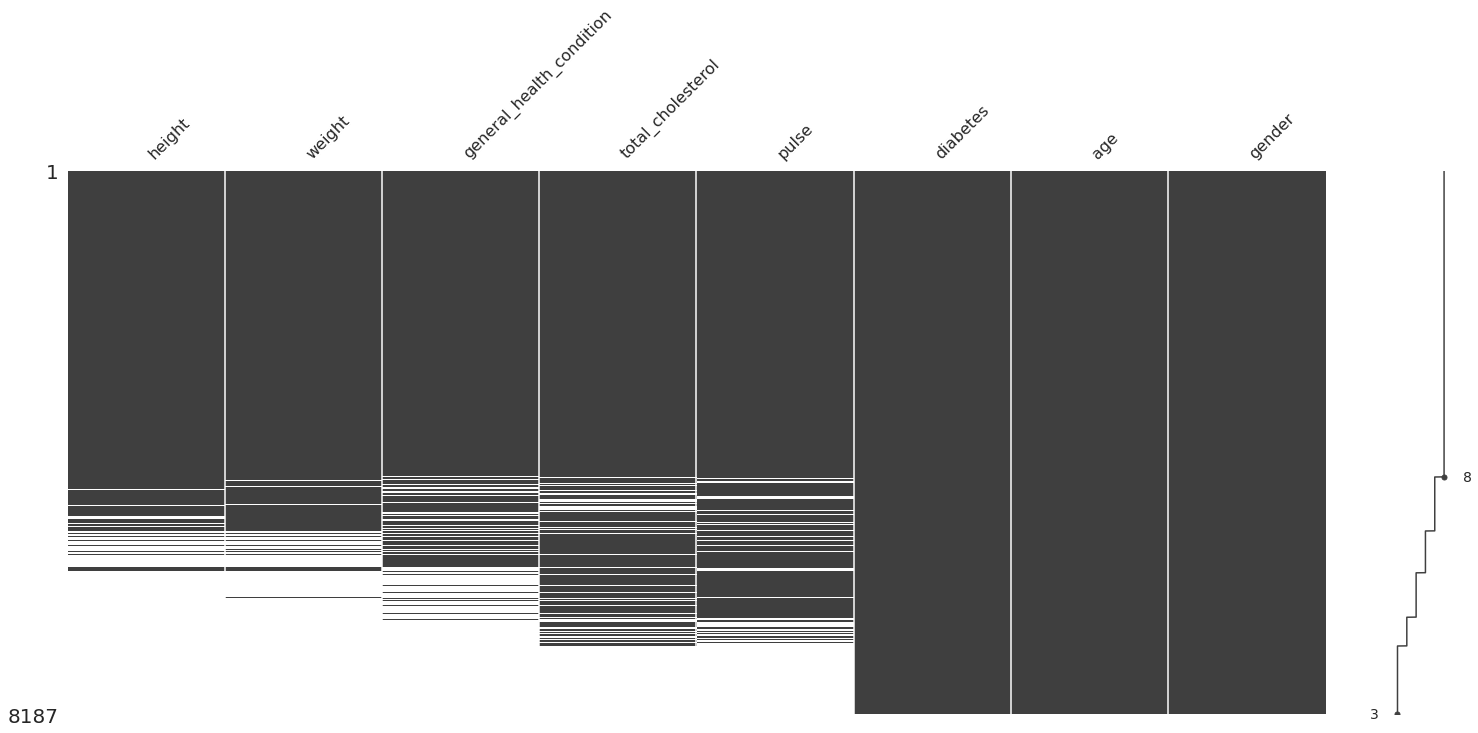

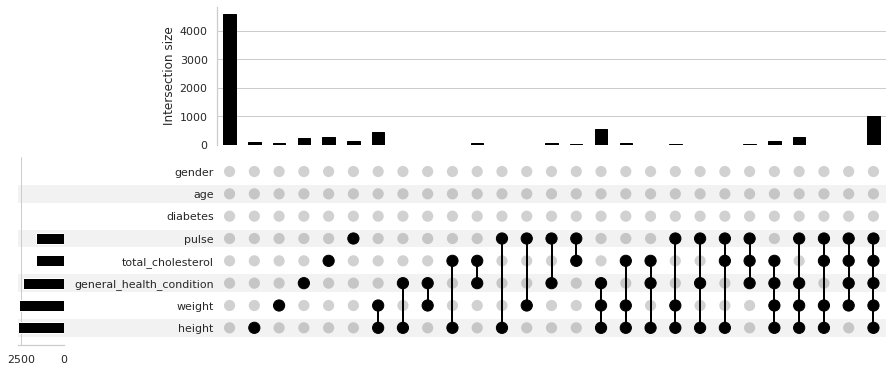

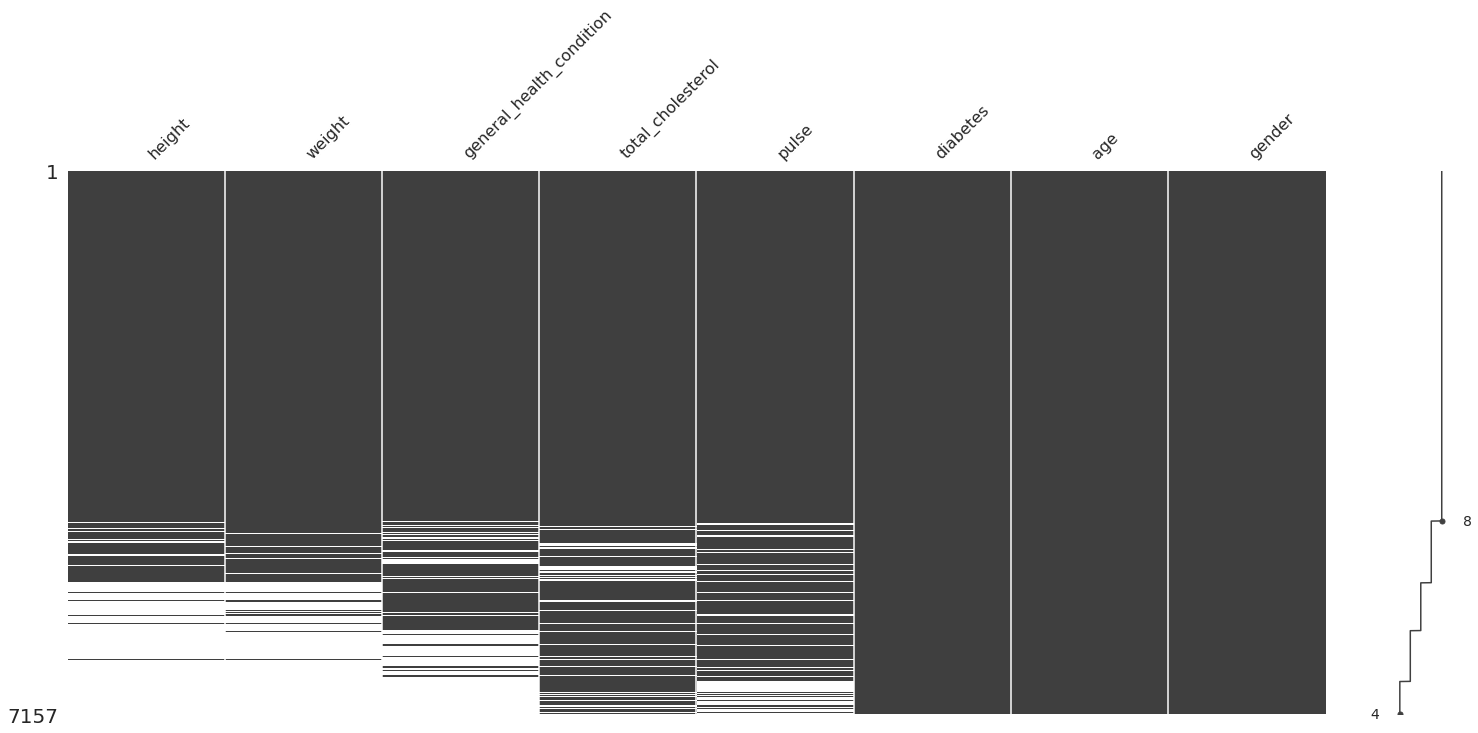

In [14]:
# cargar los datos externos
%run download_data_and_load.ipynb

## Consideracion y Evaluacion de los distintos tipos de valores faltantes

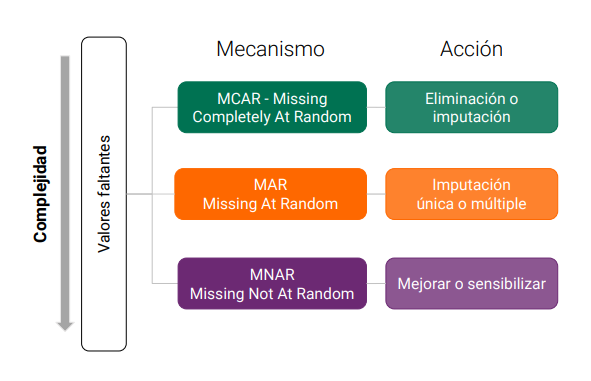

## Prueba de Hipotesis con TTest

### Existe alguna diferencia entre hombres y mujeres con la presencia o ausencia de valores en la variables Peso?

Exploraremos si la presencia o ausencia de valores faltantes es diferentes entre hombres y mujeres respecto al Peso

In [15]:

female_weight, male_weight = (
    nhanes_df
    .select_columns('gender','weight') # extraer las columnas de interes del dataframe
    .transform_column(                 # trnasformar en valores booleanos los elementos de Peso
        'weight',
        lambda x: x.isna(),
        elementwise = False
    )
    .groupby('gender')                 # agrupar segun el genero
    .weight
    .pipe(
        lambda df:(                    # extraer los dos grupos
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

In [16]:
female_weight

SEQN
93705.0     False
93709.0     False
93714.0     False
93719.0      True
93721.0     False
            ...  
102941.0     True
102943.0    False
102948.0    False
102954.0    False
102955.0     True
Name: weight, Length: 3665, dtype: bool

In [17]:
male_weight

SEQN
93706.0     False
93707.0      True
93711.0     False
93712.0     False
93713.0     False
            ...  
102946.0    False
102947.0    False
102949.0    False
102953.0    False
102956.0    False
Name: weight, Length: 3492, dtype: bool

In [18]:
# aplicacion de la prueba Ttest
scipy.stats.ttest_ind(
    a = female_weight,  # primer grupo
    b = male_weight,    # segundo grupo
    alternative='two-sided' # metodo de t-test
) 
# con el metodo utilizado lo que estamos preguntando es si existe una diferencia entre 
# la ausencia o presencia de valores de Peso? si el valor del modelo estadistico es mayor
# a 0.05 no se puede definir o rechazar la hipotesis nula de que exista alguna diferencia

Ttest_indResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239)

Como pvalue es mayor a 0.05 no podemos rechazar la hipotesis nula es decir no podemos asegurar que exista alguna diferencia entre las personas con valores faltantes. Esto sugiere que los datos no estan perdidos al azar al menos para la categoria de genero.

### Existe alguna diferencia entre hombres y mujeres con la presencia o ausencia de valores en la variable altura?

In [19]:
female_height, male_height = (
    nhanes_df
    .select_columns(['gender', 'height']) # seleccion de las variables
    .transform_column(  # transforma en booleanos los valores de height
        'height',
        lambda x: x.isna(),
        elementwise = False
    )
    .groupby('gender')  # agrupa segun el genero
    .height
    .pipe(
        lambda df:(     # extrae los dos grupos
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

In [20]:
female_height

SEQN
93705.0     False
93709.0     False
93714.0     False
93719.0      True
93721.0     False
            ...  
102941.0     True
102943.0    False
102948.0    False
102954.0    False
102955.0     True
Name: height, Length: 3665, dtype: bool

In [21]:
male_height

SEQN
93706.0     False
93707.0      True
93711.0     False
93712.0     False
93713.0     False
            ...  
102946.0    False
102947.0    False
102949.0    False
102953.0    False
102956.0    False
Name: height, Length: 3492, dtype: bool

In [22]:
# aplicacion de la prueba Ttest
# hipotesis nula: la media de ambas distribuciones son desiguales

scipy.stats.ttest_ind(
    a = female_height,
    b = male_height,
    alternative= 'two-sided'
)

Ttest_indResult(statistic=-1.0441004739954949, pvalue=0.29647418035378503)

Como el valor de p es mayor que el umbral de 0.05 se rechaza la hipotesis nula, es decir, no hay suficientes pruebas para asegurar que exista una diferencia entre hombres y mujeres en funcion de la altura. Los datos no estan perdidos al azar.

### Existe alguna diferencia entre hombre y mujeres por la presencia o ausencia de valores en la variable colesterol?

In [23]:
female_cholesterol, male_cholesterol = (
    nhanes_df
    .select_columns(['gender', 'total_cholesterol'])
    .transform_column(
        'total_cholesterol',
        lambda x: x.isna(),
        elementwise = False
    )
    .groupby('gender')
    .total_cholesterol
    .pipe(
        lambda df:(
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

In [24]:
female_cholesterol

SEQN
93705.0     False
93709.0     False
93714.0     False
93719.0     False
93721.0     False
            ...  
102941.0    False
102943.0    False
102948.0    False
102954.0    False
102955.0    False
Name: total_cholesterol, Length: 3665, dtype: bool

In [25]:
male_cholesterol

SEQN
93706.0     False
93707.0     False
93711.0     False
93712.0     False
93713.0     False
            ...  
102946.0    False
102947.0    False
102949.0    False
102953.0    False
102956.0    False
Name: total_cholesterol, Length: 3492, dtype: bool

In [26]:
# aplicamos la prueba de Ttest
# hipotesis nula: la media de ambas distribuciones son desiguales

scipy.stats.ttest_ind(
    a = female_cholesterol,
    b = male_cholesterol,
    alternative='two-sided'
)

Ttest_indResult(statistic=-0.7000351630218239, pvalue=0.48392810483409965)

Como el valor de p es menor que el umbral de 0.05, se rechaza la hipotesis nula es decir, no podemos asegurar que exista alguna diferencia entre mujeres y hombres por la presencia o ausencia de total cholesterol.

## Nueva herramienta para explorar valores faltantes

### Explorar la relacion de variables categoricas en funcion de la ausencia en otra variable mediante un grafico de Mosaico

In [27]:
# Grafico de Mosaico para las variables weight, general_health_condition, gender

(
    nhanes_df
    .select_columns('weight', 'general_health_condition', 'gender') # seleccionar columnas
    .assign(  # asignar valores NA y !NA para la variable weight dependiendo si hay o no missing
        weight = lambda df: df.weight.isna().replace([True, False], ['NA', '!NA'])
    )   # cuantificar las apariciones que existen por cada combinacion de las 3 variables
    .groupby(
        ['gender', 'general_health_condition', 'weight'],
        dropna=False, # no eliminar los valores faltantes de health
        as_index= True
    )
    .size()
)

gender  general_health_condition  weight
Female  Excellent                 !NA        212
                                  NA          65
        Fair or                   !NA        549
                                  NA          42
        Good                      !NA       1102
                                  NA         113
        Poor?                     !NA         94
                                  NA           3
        Very good                 !NA        659
                                  NA         103
        NaN                       !NA        234
                                  NA         489
Male    Excellent                 !NA        273
                                  NA          62
        Fair or                   !NA        508
                                  NA          31
        Good                      !NA       1056
                                  NA         112
        Poor?                     !NA         70
                            

Nos muestra las tres categorias tabuladas conjuntamente con sus conteos de aparicion (frecuencia)

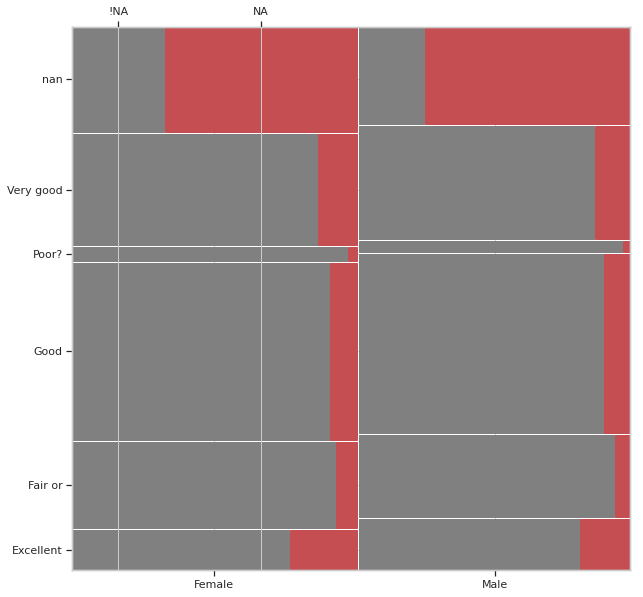

In [28]:
# visualizacion mediante un grafico de Mosaico

# size de la grafica
fig, ax = plt.subplots(figsize=(10,10))

(
    nhanes_df
    .select_columns('weight', 'general_health_condition', 'gender') # seleccionar columnas
    .assign(  # asignar valores NA y !NA para la variable weight dependiendo si hay o no missing
        weight = lambda df: df.weight.isna().replace([True, False], ['NA', '!NA'])
    )   # cuantificar las apariciones que existen por cada combinacion de las 3 variables
    .groupby(
        ['gender', 'general_health_condition', 'weight'],
        dropna=False, # no eliminar los valores faltantes de health
        as_index= True
    )
    .size()
    .pipe(
        lambda df: mosaic(
            data=df,
            properties= lambda key: {'color':'r' if 'NA' in key else 'gray'},
            horizontal=True,
            axes_label=True,
            title='',
            labelizer=lambda key:'', # coloca los nombres de las variables dentro del cuadro
            ax=ax
        )
    )
);

En la categoria pobreza, hay muy pocas observaciones mientras que el estado de salud 'Muy bien' tiene una mayor cantidad pero no mas que el estado de salud 'Bien'. Por otro lado, a las personas que responden en el estado de salud con 'Muy bien' les falta a muchas de las observaciones la variable Peso y en mayor proporcion que a las personsa que reponden 'Bien'

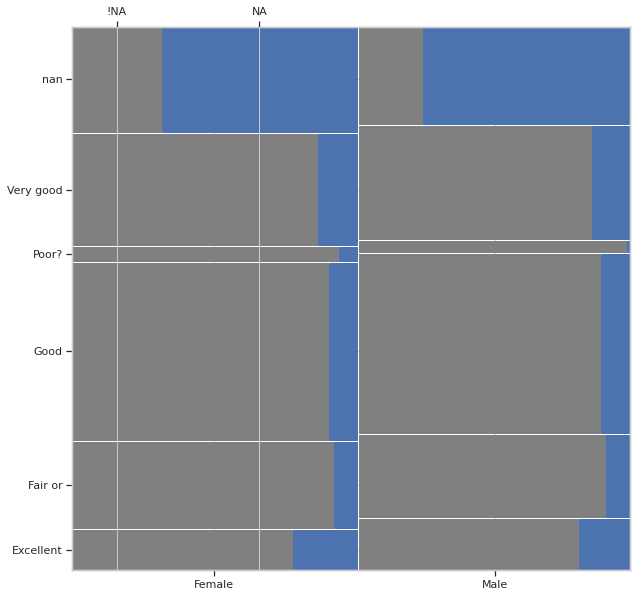

In [29]:
# Grafico de Mosaico para las variables gender, general_health_condition, height

fig, ax = plt.subplots(figsize=(10,10))

(
    nhanes_df
    .select_columns(['height', 'general_health_condition', 'gender'])  # seleccionar columnas
    .assign(    # asignar NA y !NA a la variable height dependiendo si hay o no missing
        height = lambda df: df.height.isna().replace([True, False], ['NA', '!NA'])
    )
    .groupby(
        ['gender', 'general_health_condition', 'height'],
        dropna=False,
        as_index = True
    )
    .size()
    .pipe(
        lambda df: mosaic(
            data= df,
            properties= lambda key: {'color':'b' if 'NA' in key else 'gray'},
            horizontal=True,
            axes_label=True,
            title='',
            labelizer=lambda key:'',
            ax=ax
        )
    )
);

## Tratamiento de Variables Categoricas para imputacion

### Codificacion Ordinal

In [30]:
# creamos una copia de los datos
nhanes_transformed_df = nhanes_df.copy(deep=True) # deep para asegurar que tiene una direccion en memoria distinta


Dado un conjunto de datos con dos caracteristicas, encontraremos los valores unicos por caracteristica y los transformaremos utilizando una codificacion ordinal

In [31]:
X = [['Male'], ['Female'], ['Female']]
X

[['Male'], ['Female'], ['Female']]

In [32]:
# creamos un encoder para agrupar la informacion y codificarla
encoder = sklearn.preprocessing.OrdinalEncoder() 

In [33]:
# codificamos la lista anterior
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

El hombre quedo con la codificacion 1 y la mujer con 0. Para cuando hay muchas categorias utilizamos el metodos categories_

In [34]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

Calcular la inversa de la transformacion de manera que si hay un 1 aparezca un hombre y si hay un 0 aparezca una mujer

In [36]:
encoder.inverse_transform([[1],[1],[0]])

array([['Male'],
       ['Male'],
       ['Female']], dtype=object)

### Aplicando la codificacion ordinal a todas las variables categoricas

In [37]:
# obtener las variables de tipo objeto y categorica
nhanes_df.select_dtypes(include=[object, 'category'])

,general_health_condition,gender
SEQN,,
93705.0,Good,Female
93706.0,Very good,Male
93707.0,Good,Male
93709.0,NaN,Female
93711.0,Very good,Male
...,...,...
102949.0,Excellent,Male
102953.0,Fair or,Male
102954.0,Good,Female


In [40]:
# obtener solo los nombres con valores de tipo object y category
categorical_columns = nhanes_df.select_dtypes(include=[object, 'category']).columns

In [41]:
# funcion que permite componer instrucciones de transfomacion en los datos
categorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder='passthrought'
)

ColumnTransformer(remainder='passthrought',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 Index(['general_health_condition', 'gender'], dtype='object'))])